In [6]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [7]:
filepath = 'Data W9371UM ULTRASONIK.xlsx'

In [8]:
# CELL 1: Load Data dengan Parsing Datetime yang Benar

def parse_datetime_safe(col):
    """
    Parse datetime dengan penanganan format yang lebih baik
    """
    col = col.astype(str).str.strip()  # hilangkan spasi
    parsed = pd.to_datetime(col, format='%d/%m/%Y %H:%M:%S', errors='coerce', dayfirst=True)
    
    # Jika masih banyak NaT, coba parse otomatis (untuk format campuran)
    if parsed.isna().sum() > len(col) * 0.5:
        parsed = pd.to_datetime(col, errors='coerce', dayfirst=True, infer_datetime_format=True)
    
    return parsed


def load_and_clean_data(filepath, sheet_name=0):
    """
    Load data dengan parsing datetime yang aman
    """
    try:
        df = pd.read_excel(filepath, sheet_name=sheet_name)
        
        print(f"\n{'='*60}")
        print(f"Sheet: {sheet_name}")
        print(f"{'='*60}")
        
        # PERBAIKAN: Gunakan parse_datetime_safe()
        df['GPSTIME'] = parse_datetime_safe(df['GPSTIME'])
        
        # Parse kolom datetime lain jika ada
        if 'RECEIVE TIME' in df.columns:
            df['RECEIVE TIME'] = parse_datetime_safe(df['RECEIVE TIME'])
        
        # Convert kolom numerik
        df['VALUE FUEL SENSOR'] = pd.to_numeric(df['VALUE FUEL SENSOR'], errors='coerce')
        df['VOLTAGE FUEL SENSOR'] = pd.to_numeric(df['VOLTAGE FUEL SENSOR'], errors='coerce')
        df['ODOMETER'] = pd.to_numeric(df['ODOMETER'], errors='coerce')
        df['SPEED'] = pd.to_numeric(df['SPEED'], errors='coerce')
        
        # Hapus baris dengan GPSTIME invalid
        initial_count = len(df)
        df = df.dropna(subset=['GPSTIME'])
        removed = initial_count - len(df)
        if removed > 0:
            print(f"⚠️ Removed {removed} rows dengan GPSTIME invalid")
        
        # Sort dan filter
        df = df.sort_values('GPSTIME').reset_index(drop=True)
        df_active = df[df['ACC'] == 'ON'].copy()
        
        print(f"Total data: {len(df)}")
        print(f"Data ACC ON: {len(df_active)}")
        print(f"Rentang: {df_active['GPSTIME'].min()} s/d {df_active['GPSTIME'].max()}")
        
        # Tampilkan bulan dan hari
        months = df_active['GPSTIME'].dt.month.unique()
        days = sorted(df_active['GPSTIME'].dt.day.unique())
        print(f"Bulan: {months} (November = 11)")
        print(f"Hari: {days}")
        
        # Validasi: pastikan hanya November
        if len(months) > 1 or (len(months) == 1 and months[0] != 11):
            print(f"\n⚠️ WARNING: Data mengandung bulan selain November!")
            print(f"   Detected months: {months}")
        
        return df, df_active
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None


# Load kedua sheet
xls = pd.ExcelFile(filepath)
sheet_names = xls.sheet_names
print(f"Available sheets: {sheet_names}")

df1, df1_active = load_and_clean_data(filepath, sheet_names[0])
df2, df2_active = load_and_clean_data(filepath, sheet_names[1])

# Combine data
if df1 is not None and df2 is not None:
    df_combined = pd.concat([df1, df2], ignore_index=True)
    df_combined_active = pd.concat([df1_active, df2_active], ignore_index=True)
    print(f"\n{'='*60}")
    print("COMBINED DATA")
    print(f"{'='*60}")
    print(f"Total data gabungan: {len(df_combined)}")
    print(f"Total data ACC ON gabungan: {len(df_combined_active)}")

Available sheets: ['W9371UM BARU', 'W9371UM LAMA']

Sheet: W9371UM BARU
Total data: 1025
Data ACC ON: 733
Rentang: 2025-11-06 03:06:00 s/d 2025-11-09 03:37:00
Bulan: [11] (November = 11)
Hari: [np.int32(6), np.int32(7), np.int32(8), np.int32(9)]

Sheet: W9371UM LAMA
⚠️ Removed 13926 rows dengan GPSTIME invalid
Total data: 11801
Data ACC ON: 10359
Rentang: 2025-01-08 14:12:51 s/d 2025-12-08 21:48:09
Bulan: [ 1  2  4  5  6  7  8  9 10 11 12] (November = 11)
Hari: [np.int32(7), np.int32(8), np.int32(9)]

⚠️ WARNING: Data mengandung bulan selain November!
   Detected months: [ 1  2  4  5  6  7  8  9 10 11 12]

COMBINED DATA
Total data gabungan: 12826
Total data ACC ON gabungan: 11092


In [ ]:
def load_and_clean_data(filepath, sheet_name=0):
    """
    Load data dari sheet tertentu dan bersihkan kolom-kolom penting
    """
    try:
        # Load data dari sheet tertentu
        df = pd.read_excel(filepath, sheet_name=sheet_name)
        
        # Check and use correct column names
        print(f"\n{'='*60}")
        print(f"Sheet: {sheet_name}")
        print(f"{'='*60}")
        print("Available columns:")
        print(df.columns.tolist())
        
        # Adjust these column names based on actual data
        df['GPSTIME'] = pd.to_datetime(df['GPSTIME'])
        df['VALUE FUEL SENSOR'] = pd.to_numeric(df['VALUE FUEL SENSOR'], errors='coerce')
        df['VOLTAGE FUEL SENSOR'] = pd.to_numeric(df['VOLTAGE FUEL SENSOR'], errors='coerce')
        
        df = df.sort_values('GPSTIME').reset_index(drop=True)
        df_active = df[df['ACC'] == 'ON'].copy()
        
        print(f"Total data: {len(df)}")
        print(f"Data dengan ACC ON: {len(df_active)}")
        print(f"Rentang waktu: {df['GPSTIME'].min()} s/d {df['GPSTIME'].max()}")
        
        return df, df_active
    except Exception as e:
        print(f"Error di sheet {sheet_name}: {e}")
        return None, None

# Load both sheets
filepath = 'Data W9371UM ULTRASONIK.xlsx'

# Get sheet names
xls = pd.ExcelFile(filepath)
sheet_names = xls.sheet_names
print(f"Available sheets: {sheet_names}")

# Load data dari kedua sheet
df1, df1_active = load_and_clean_data(filepath, sheet_name=sheet_names[0])
df2, df2_active = load_and_clean_data(filepath, sheet_name=sheet_names[1])

# Combine data jika diperlukan
if df1 is not None and df2 is not None:
    df_combined = pd.concat([df1, df2], ignore_index=True)
    df_combined_active = pd.concat([df1_active, df2_active], ignore_index=True)
    print(f"\n{'='*60}")
    print("COMBINED DATA")
    print(f"{'='*60}")
    print(f"Total data gabungan: {len(df_combined)}")
    print(f"Total data ACC ON gabungan: {len(df_combined_active)}")

Available sheets: ['W9371UM BARU', 'W9371UM LAMA']

Sheet: W9371UM BARU
Available columns:
['NO', 'GPSTIME', 'RECEIVE TIME', 'ACC', 'SPEED', 'ODOMETER', 'ALTITUDE', 'EVENT', 'STATUS KENDARAAN', 'STATUS_OVERSPEED', 'LOCATION CODE', 'LOCATION', 'ADDRESS', 'KOTA', 'PROVINSI', 'LON', 'LAT', 'AKI', 'GSM SIGNAL', 'AIN 1', 'AIN 2', 'AIN 3', 'DIN 1', 'DIN 2', 'DIN 3', 'DOUT 1', 'DOUT 2', 'VALUE FUEL SENSOR', 'UNIT FUEL SENSOR', 'VOLTAGE FUEL SENSOR']
Total data: 1025
Data dengan ACC ON: 733
Rentang waktu: 2025-06-11 00:21:00 s/d 2025-09-11 23:37:00

Sheet: W9371UM LAMA
Available columns:
['NO', 'GPSTIME', 'RECEIVE TIME', 'ACC', 'SPEED', 'ODOMETER', 'ALTITUDE', 'HEADING', 'STATUS KENDARAAN', 'STATUS GEO LOCATION', 'ADDRESS', 'KOTA', 'PROVINSI', 'LON', 'LAT', 'GPS SATELITE', 'GSM SIGNAL', 'MAIN POWER VOLTAGE', 'AIN 1', 'AIN 3', 'DIN 1', 'DIN 2', 'DIN 3', 'DIN 4', 'DOUT 1', 'DOUT 2', 'VALUE FUEL SENSOR', 'UNIT FUEL SENSOR', 'VOLTAGE FUEL SENSOR']
Total data: 25727
Data dengan ACC ON: 22227
Rentan

In [ ]:
# BAGIAN 2: PERHITUNGAN KONSUMSI BBM
def calculate_fuel_consumption(df):
    """
    Hitung konsumsi BBM berdasarkan perubahan odometer dan fuel
    
    Metode:
    1. Deteksi trip berdasarkan gap waktu > 30 menit atau ACC OFF
    2. Untuk setiap trip, hitung: jarak tempuh dan BBM terpakai
    3. Konsumsi = jarak / BBM (km/L)
    """
    
    df = df.copy()
    df['time_diff'] = df['GPSTIME'].diff().dt.total_seconds() / 60  # dalam menit
    df['odo_diff'] = df['ODOMETER'].diff()
    df['fuel_diff'] = df['VALUE FUEL SENSOR'].diff()
    
    # Identifikasi trip baru (gap > 30 menit atau odometer reset)
    df['new_trip'] = ((df['time_diff'] > 30) |  #ketika gps time > 30 
                      (df['odo_diff'] < 0) | 
                      (df['fuel_diff'] > 50))  # fuel naik drastis = isi ulang
    
    df['trip_id'] = df['new_trip'].cumsum()
    
    # Analisis per trip
    trip_analysis = []
    
    for trip_id, trip_data in df.groupby('trip_id'):
        if len(trip_data) < 2:
            continue
            
        # Hitung total jarak dan BBM untuk trip ini
        start_odo = trip_data['ODOMETER'].iloc[0]
        end_odo = trip_data['ODOMETER'].iloc[-1]
        distance = end_odo - start_odo
        
        start_fuel = trip_data['VALUE FUEL SENSOR'].iloc[0]
        end_fuel = trip_data['VALUE FUEL SENSOR'].iloc[-1]
        fuel_used = start_fuel - end_fuel  # BBM berkurang
        
        # Filter trip valid (jarak > 1 km, BBM terpakai > 0.5 L)
        if distance > 1 and fuel_used > 0.5:
            consumption = distance / fuel_used  # km/L
            
            trip_analysis.append({
                'trip_id': trip_id,
                'start_time': trip_data['GPSTIME'].iloc[0],
                'end_time': trip_data['GPSTIME'].iloc[-1],
                'duration_hours': (trip_data['GPSTIME'].iloc[-1] - 
                                 trip_data['GPSTIME'].iloc[0]).total_seconds() / 3600,
                'distance_km': distance,
                'fuel_used_L': fuel_used,
                'consumption_kmL': consumption,
                'avg_speed': trip_data['SPEED'].mean(),
                'max_speed': trip_data['SPEED'].max(),
                'data_points': len(trip_data)
            })
    
    return pd.DataFrame(trip_analysis)

# JALANKAN ANALISIS UNTUK KEDUA SHEET
print("\n" + "="*60)
print("ANALISIS KONSUMSI BBM - SHEET 1")
print("="*60)
trip_analysis_1 = calculate_fuel_consumption(df1_active)
print(trip_analysis_1)

print("\n" + "="*60)
print("ANALISIS KONSUMSI BBM - SHEET 2")
print("="*60)
trip_analysis_2 = calculate_fuel_consumption(df2_active)
print(trip_analysis_2)

print("\n" + "="*60)
print("ANALISIS KONSUMSI BBM - GABUNGAN")
print("="*60)
trip_analysis_combined = calculate_fuel_consumption(df_combined_active)
print(trip_analysis_combined)

# RINGKASAN STATISTIK
print("\n" + "="*60)
print("RINGKASAN STATISTIK KONSUMSI")
print("="*60)
print(f"\nSheet 1 - Rata-rata konsumsi: {trip_analysis_1['consumption_kmL'].mean():.2f} km/L")
print(f"Sheet 2 - Rata-rata konsumsi: {trip_analysis_2['consumption_kmL'].mean():.2f} km/L")
print(f"Gabungan - Rata-rata konsumsi: {trip_analysis_combined['consumption_kmL'].mean():.2f} km/L")


ANALISIS KONSUMSI BBM - SHEET 1
   trip_id          start_time            end_time  duration_hours  \
0        3 2025-06-11 05:35:00 2025-06-11 05:51:00        0.266667   
1        8 2025-07-11 09:55:00 2025-07-11 10:32:00        0.616667   
2       13 2025-07-11 19:35:00 2025-07-11 20:20:00        0.750000   
3       14 2025-07-11 20:20:00 2025-07-11 22:31:00        2.183333   
4       15 2025-07-11 22:31:00 2025-07-11 22:38:00        0.116667   

   distance_km  fuel_used_L  consumption_kmL  avg_speed  max_speed  \
0          9.8         3.65         2.684932  41.000000         61   
1         11.9         4.48         2.656250  26.916667         61   
2          6.8         1.92         3.541667  14.548387         51   
3         20.1         9.23         2.177681  19.041096         57   
4          3.1         1.05         2.952381  25.500000         44   

   data_points  
0           22  
1           36  
2           31  
3           73  
4            8  

ANALISIS KONSUMSI BBM 

In [33]:
# BAGIAN 3: AGREGASI KONSUMSI PER 4 HARI
def aggregate_4day_periods(trip_df):
    """
    Agregasi data trip menjadi periode 4 hari
    """
    
    if len(trip_df) == 0:
        return pd.DataFrame()
    
    # Tambahkan kolom tanggal
    trip_df['date'] = trip_df['start_time'].dt.date
    
    # Tentukan rentang data
    min_date = trip_df['date'].min()
    max_date = trip_df['date'].max()
    
    # Buat segmen 4 hari
    periods = []
    current_date = min_date
    period_num = 1
    
    while current_date <= max_date:
        period_end = current_date + timedelta(days=3)  # 4 hari (0-3)
        
        # Filter trip dalam periode ini
        period_trips = trip_df[
            (trip_df['date'] >= current_date) & 
            (trip_df['date'] <= period_end)
        ]
        
        if len(period_trips) > 0:
            total_distance = period_trips['distance_km'].sum()
            total_fuel = period_trips['fuel_used_L'].sum()
            
            if total_fuel > 0:
                avg_consumption = total_distance / total_fuel
                
                periods.append({
                    'period_num': period_num,
                    'start_date': current_date,
                    'end_date': period_end,
                    'num_trips': len(period_trips),
                    'total_distance_km': total_distance,
                    'total_fuel_L': total_fuel,
                    'avg_consumption_kmL': avg_consumption,
                    'avg_speed': period_trips['avg_speed'].mean(),
                    'total_duration_hours': period_trips['duration_hours'].sum()
                })
        
        current_date = period_end + timedelta(days=1)
        period_num += 1

    return pd.DataFrame(periods)
    
# AGREGASI UNTUK KEDUA SHEET
print("\n" + "="*60)
print("AGREGASI 4 HARI - SHEET 1")
print("="*60)
agg_4day_1 = aggregate_4day_periods(trip_analysis_1)
print(agg_4day_1)

print("\n" + "="*60)
print("AGREGASI 4 HARI - SHEET 2")
print("="*60)
agg_4day_2 = aggregate_4day_periods(trip_analysis_2)
print(agg_4day_2)

print("\n" + "="*60)
print("AGREGASI 4 HARI - GABUNGAN")
print("="*60)
agg_4day_combined = aggregate_4day_periods(trip_analysis_combined)
print(agg_4day_combined)


AGREGASI 4 HARI - SHEET 1


   period_num  start_date    end_date  num_trips  total_distance_km  \
0           1  2025-06-11  2025-06-14          1                9.8   
1           8  2025-07-09  2025-07-12          4               41.9   

   total_fuel_L  avg_consumption_kmL  avg_speed  total_duration_hours  
0          3.65             2.684932  41.000000              0.266667  
1         16.68             2.511990  21.501537              3.666667  

AGREGASI 4 HARI - SHEET 2
   period_num  start_date    end_date  num_trips  total_distance_km  \
0           1  2025-07-16  2025-07-19          1          38.700012   
1           6  2025-08-05  2025-08-08          3           5.400146   
2          12  2025-08-29  2025-09-01          1          60.000000   

   total_fuel_L  avg_consumption_kmL  avg_speed  total_duration_hours  
0          5.90             6.559324  14.591772              3.090278  
1          4.93             1.095364  15.082974              0.530833  
2         11.20             5.357143  35.1

In [34]:
# ============================================================
# BAGIAN 4: STATISTIK DESKRIPTIF & VISUALISASI
# ============================================================

def descriptive_statistics(period_df, group_name):
    """
    Hitung statistik deskriptif untuk satu kelompok periode
    """
    
    if len(period_df) == 0:
        return None
    
    consumption = period_df['avg_consumption_kmL'].values
    
    stats_dict = {
        'Group': group_name,
        'N': len(consumption),
        'Mean': np.mean(consumption),
        'Median': np.median(consumption),
        'Std Dev': np.std(consumption, ddof=1) if len(consumption) > 1 else 0,
        'Min': np.min(consumption),
        'Max': np.max(consumption),
        'Q1': np.percentile(consumption, 25),
        'Q3': np.percentile(consumption, 75),
        'Skewness': stats.skew(consumption) if len(consumption) > 2 else 0,
        'Kurtosis': stats.kurtosis(consumption) if len(consumption) > 2 else 0
    }
    
    return stats_dict
# HITUNG STATISTIK UNTUK KEDUA SHEET
print("\n" + "="*60)
print("STATISTIK DESKRIPTIF - AGREGASI 4 HARI")
print("="*60)

stats_1 = descriptive_statistics(agg_4day_1, "Sheet 1")
stats_2 = descriptive_statistics(agg_4day_2, "Sheet 2")
stats_combined = descriptive_statistics(agg_4day_combined, "Gabungan")

# Tampilkan dalam format tabel
stats_results = [stats_1, stats_2, stats_combined]
stats_df = pd.DataFrame(stats_results)
print(stats_df.to_string(index=False))




STATISTIK DESKRIPTIF - AGREGASI 4 HARI
   Group  N     Mean   Median  Std Dev      Min      Max       Q1       Q3  Skewness  Kurtosis
 Sheet 1  2 2.598461 2.598461 0.122288 2.511990 2.684932 2.555226 2.641696   0.00000  0.000000
 Sheet 2  3 4.337277 5.357143 2.871203 1.095364 6.559324 3.226254 5.958233  -0.57022 -1.500000
Gabungan  6 3.260807 2.598461 2.264926 0.451406 6.559324 2.128033 4.689090   0.38302 -1.149204



PENGUJIAN HIPOTESIS - INDEPENDENT T-TEST

UJI ASUMSI: Sheet 1 vs Sheet 2

1. UJI NORMALITAS (Shapiro-Wilk Test)
------------------------------------------------------------
Sheet 1:
   Statistic: nan, p-value: nan
   ✗ Data TIDAK berdistribusi normal (p < 0.05)

Sheet 2:
   Statistic: 0.9054, p-value: 0.4028
   ✓ Data berdistribusi NORMAL (p > 0.05)

2. UJI HOMOGENITAS VARIANS (Levene's Test)
------------------------------------------------------------
Statistic: 1.1220, p-value: 0.3672
✓ Varians HOMOGEN (p > 0.05)

3. UJI INDEPENDEN T-TEST
------------------------------------------------------------
Menggunakan: Student's t-test
t-statistic: -0.8121
p-value: 0.4762
✓ TIDAK ada perbedaan signifikan (p ≥ 0.05)

Interpretasi:
  Sheet 1 - Mean: 2.60 ± 0.09 km/L
  Sheet 2 - Mean: 4.34 ± 2.34 km/L
  Selisih: 1.74 km/L

VISUALISASI PERBANDINGAN


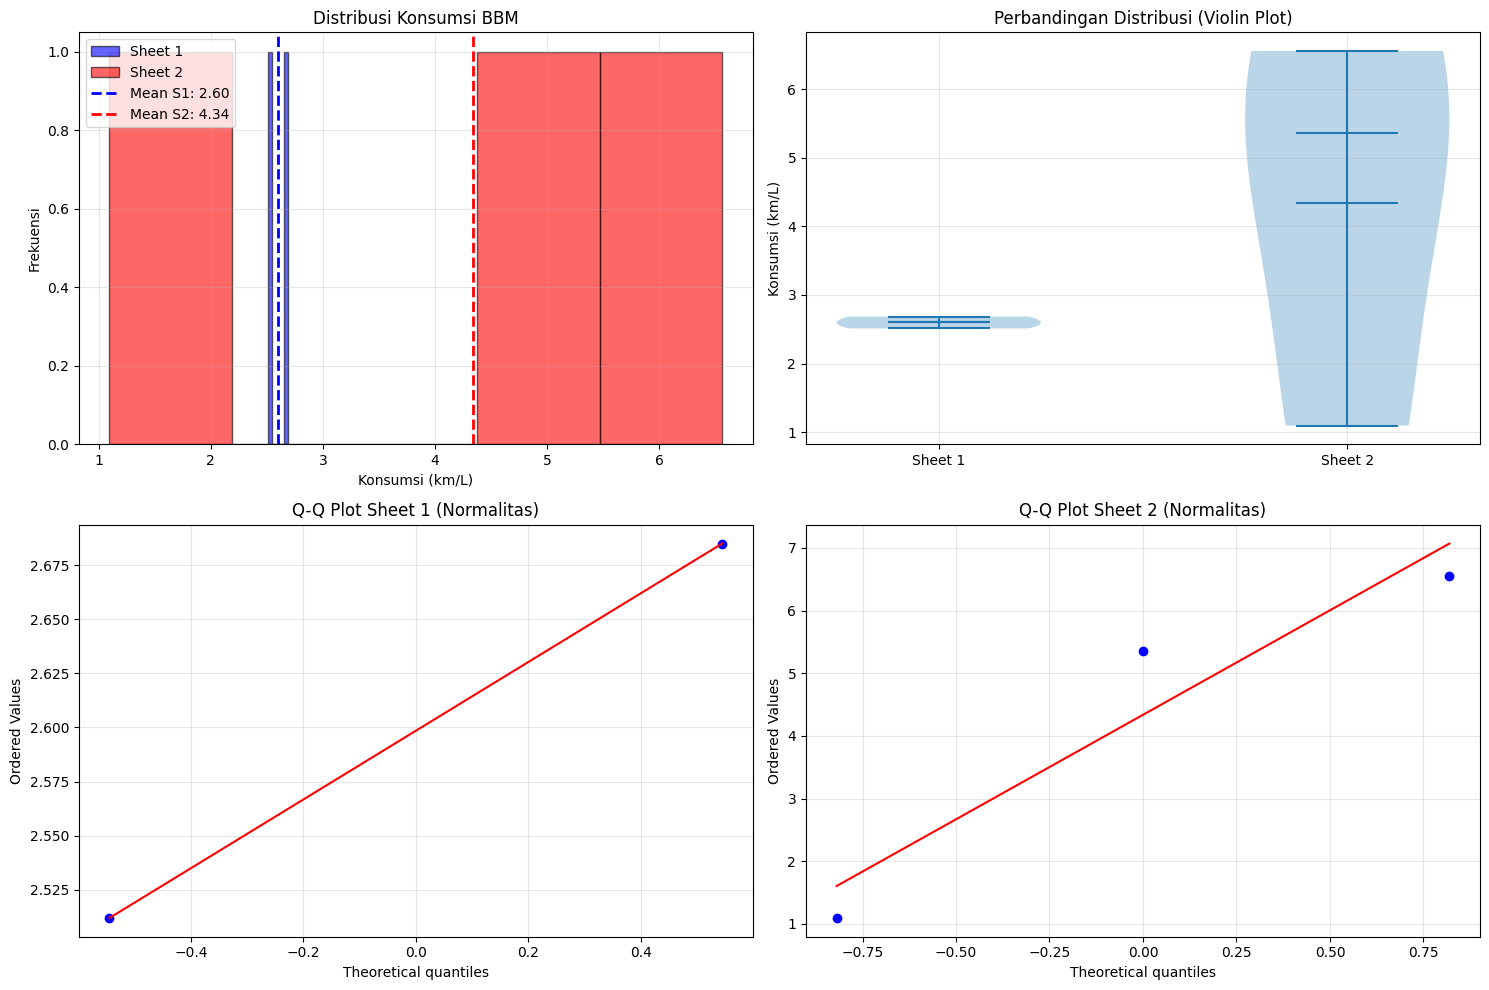


MENYIMPAN HASIL ANALISIS
✓ File 'Hasil_Analisis_BBM_Lengkap.xlsx' berhasil disimpan

RINGKASAN ANALISIS LENGKAP

Sheet 1 (Agregasi 4 Hari):              
  Total Periode: 2
  Total Trip: 5
  Rata-rata Konsumsi: 2.60 ± 0.12 km/L
  Total Jarak: 51.70 km
  Total BBM: 20.33 L

Sheet 2 (Agregasi 4 Hari):              
  Total Periode: 3
  Total Trip: 5
  Rata-rata Konsumsi: 4.34 ± 2.87 km/L
  Total Jarak: 104.10 km
  Total BBM: 22.03 L

Gabungan (Agregasi 4 Hari):             
  Total Periode: 6
  Total Trip: 10
  Rata-rata Konsumsi: 3.26 ± 2.26 km/L
  Total Jarak: 155.80 km
  Total BBM: 42.36 L



In [35]:
# BAGIAN 5: UJI ASUMSI & UJI STATISTIK
def test_assumptions(data1, data2, group1_name, group2_name):
    """
    Uji asumsi untuk independent t-test:
    1. Normalitas (Shapiro-Wilk)
    2. Homogenitas varians (Levene's test)
    """
    
    print("\n" + "="*60)
    print(f"UJI ASUMSI: {group1_name} vs {group2_name}")
    print("="*60)
    
    # 1. Uji Normalitas
    print("\n1. UJI NORMALITAS (Shapiro-Wilk Test)")
    print("-" * 60)
    
    stat1, p1 = stats.shapiro(data1)
    stat2, p2 = stats.shapiro(data2)
    
    print(f"{group1_name}:")
    print(f"   Statistic: {stat1:.4f}, p-value: {p1:.4f}")
    if p1 > 0.05:
        print(f"   ✓ Data berdistribusi NORMAL (p > 0.05)")
    else:
        print(f"   ✗ Data TIDAK berdistribusi normal (p < 0.05)")
    
    print(f"\n{group2_name}:")
    print(f"   Statistic: {stat2:.4f}, p-value: {p2:.4f}")
    if p2 > 0.05:
        print(f"   ✓ Data berdistribusi NORMAL (p > 0.05)")
    else:
        print(f"   ✗ Data TIDAK berdistribusi normal (p < 0.05)")
    
    # 2. Uji Homogenitas Varians
    print("\n2. UJI HOMOGENITAS VARIANS (Levene's Test)")
    print("-" * 60)
    
    stat_lev, p_lev = stats.levene(data1, data2)
    
    print(f"Statistic: {stat_lev:.4f}, p-value: {p_lev:.4f}")
    if p_lev > 0.05:
        print("✓ Varians HOMOGEN (p > 0.05)")
        equal_var = True
    else:
        print("✗ Varians TIDAK homogen (p < 0.05)")
        print("  → Akan menggunakan Welch's t-test")
        equal_var = False
    
    return (p1 > 0.05 and p2 > 0.05), equal_var

# JALANKAN UJI ASUMSI UNTUK KEDUA SHEET
print("\n" + "="*80)
print("PENGUJIAN HIPOTESIS - INDEPENDENT T-TEST")
print("="*80)

# Ambil data konsumsi dari agregasi 4 hari
data1 = agg_4day_1['avg_consumption_kmL'].dropna().values
data2 = agg_4day_2['avg_consumption_kmL'].dropna().values

# Uji Asumsi
normality, equal_var = test_assumptions(data1, data2, "Sheet 1", "Sheet 2")

# BAGIAN 6: UJI INDEPENDEN T-TEST
print("\n" + "="*60)
print("3. UJI INDEPENDEN T-TEST")
print("-" * 60)

if len(data1) < 2 or len(data2) < 2:
    print("✗ Data tidak cukup untuk t-test (minimal 2 data per group)")
else:
    # Pilih t-test sesuai asumsi homogenitas
    t_stat, p_value = stats.ttest_ind(data1, data2, equal_var=equal_var)
    
    test_type = "Student's t-test" if equal_var else "Welch's t-test"
    print(f"Menggunakan: {test_type}")
    print(f"t-statistic: {t_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print(f"✗ Ada perbedaan SIGNIFIKAN (p < 0.05)")
    else:
        print(f"✓ TIDAK ada perbedaan signifikan (p ≥ 0.05)")
    
    print(f"\nInterpretasi:")
    print(f"  Sheet 1 - Mean: {np.mean(data1):.2f} ± {np.std(data1):.2f} km/L")
    print(f"  Sheet 2 - Mean: {np.mean(data2):.2f} ± {np.std(data2):.2f} km/L")
    print(f"  Selisih: {abs(np.mean(data1) - np.mean(data2)):.2f} km/L")

# BAGIAN 7: VISUALISASI UJI STATISTIK
print("\n" + "="*60)
print("VISUALISASI PERBANDINGAN")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Distribution Plot dengan Histogram
axes[0, 0].hist(data1, bins=5, alpha=0.6, label='Sheet 1', color='blue', edgecolor='black')
axes[0, 0].hist(data2, bins=5, alpha=0.6, label='Sheet 2', color='red', edgecolor='black')
axes[0, 0].axvline(np.mean(data1), color='blue', linestyle='--', linewidth=2, label=f'Mean S1: {np.mean(data1):.2f}')
axes[0, 0].axvline(np.mean(data2), color='red', linestyle='--', linewidth=2, label=f'Mean S2: {np.mean(data2):.2f}')
axes[0, 0].set_xlabel('Konsumsi (km/L)')
axes[0, 0].set_ylabel('Frekuensi')
axes[0, 0].set_title('Distribusi Konsumsi BBM')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Violin Plot
parts = axes[0, 1].violinplot([data1, data2], positions=[1, 2], showmeans=True, showmedians=True)
axes[0, 1].set_xticks([1, 2])
axes[0, 1].set_xticklabels(['Sheet 1', 'Sheet 2'])
axes[0, 1].set_ylabel('Konsumsi (km/L)')
axes[0, 1].set_title('Perbandingan Distribusi (Violin Plot)')
axes[0, 1].grid(alpha=0.3)

# 3. Q-Q Plot untuk Normalitas
stats.probplot(data1, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot Sheet 1 (Normalitas)')
axes[1, 0].grid(alpha=0.3)

# 4. Q-Q Plot Sheet 2
stats.probplot(data2, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot Sheet 2 (Normalitas)')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# BAGIAN 8: EXPORT HASIL ANALISIS
print("\n" + "="*60)
print("MENYIMPAN HASIL ANALISIS")
print("="*60)

# Buat DataFrame untuk hasil t-test
if len(data1) >= 2 and len(data2) >= 2:
    t_stat, p_value = stats.ttest_ind(data1, data2, equal_var=equal_var)
    
    ttest_results = pd.DataFrame({
        'Comparison': ['Sheet 1 vs Sheet 2'],
        'Sheet1_Mean': [np.mean(data1)],
        'Sheet1_StdDev': [np.std(data1)],
        'Sheet1_N': [len(data1)],
        'Sheet2_Mean': [np.mean(data2)],
        'Sheet2_StdDev': [np.std(data2)],
        'Sheet2_N': [len(data2)],
        't_statistic': [t_stat],
        'p_value': [p_value],
        'Significant': ['Yes' if p_value < 0.05 else 'No']
    })
else:
    ttest_results = pd.DataFrame()

# Export semua hasil
with pd.ExcelWriter('Hasil_Analisis_BBM_Lengkap.xlsx', engine='openpyxl') as writer:
    # Trip Analysis
    trip_analysis_1.to_excel(writer, sheet_name='Trip_Sheet1', index=False)
    trip_analysis_2.to_excel(writer, sheet_name='Trip_Sheet2', index=False)
    trip_analysis_combined.to_excel(writer, sheet_name='Trip_Gabungan', index=False)
    
    # Agregasi 4 Hari
    agg_4day_1.to_excel(writer, sheet_name='Agg_4Day_Sheet1', index=False)
    agg_4day_2.to_excel(writer, sheet_name='Agg_4Day_Sheet2', index=False)
    agg_4day_combined.to_excel(writer, sheet_name='Agg_4Day_Gabungan', index=False)
    
    # Statistik Deskriptif
    stats_df.to_excel(writer, sheet_name='Statistik_Deskriptif', index=False)
    
    # Hasil T-Test
    if not ttest_results.empty:
        ttest_results.to_excel(writer, sheet_name='T_Test_Results', index=False)

print("✓ File 'Hasil_Analisis_BBM_Lengkap.xlsx' berhasil disimpan")

# RINGKASAN LENGKAP
print("\n" + "="*80)
print("RINGKASAN ANALISIS LENGKAP")
print("="*80)

print(f"\n{'Sheet 1 (Agregasi 4 Hari):':<40}")
print(f"  Total Periode: {len(agg_4day_1)}")
print(f"  Total Trip: {trip_analysis_1.shape[0]}")
print(f"  Rata-rata Konsumsi: {agg_4day_1['avg_consumption_kmL'].mean():.2f} ± {agg_4day_1['avg_consumption_kmL'].std():.2f} km/L")
print(f"  Total Jarak: {agg_4day_1['total_distance_km'].sum():.2f} km")
print(f"  Total BBM: {agg_4day_1['total_fuel_L'].sum():.2f} L")

print(f"\n{'Sheet 2 (Agregasi 4 Hari):':<40}")
print(f"  Total Periode: {len(agg_4day_2)}")
print(f"  Total Trip: {trip_analysis_2.shape[0]}")
print(f"  Rata-rata Konsumsi: {agg_4day_2['avg_consumption_kmL'].mean():.2f} ± {agg_4day_2['avg_consumption_kmL'].std():.2f} km/L")
print(f"  Total Jarak: {agg_4day_2['total_distance_km'].sum():.2f} km")
print(f"  Total BBM: {agg_4day_2['total_fuel_L'].sum():.2f} L")

print(f"\n{'Gabungan (Agregasi 4 Hari):':<40}")
print(f"  Total Periode: {len(agg_4day_combined)}")
print(f"  Total Trip: {trip_analysis_combined.shape[0]}")
print(f"  Rata-rata Konsumsi: {agg_4day_combined['avg_consumption_kmL'].mean():.2f} ± {agg_4day_combined['avg_consumption_kmL'].std():.2f} km/L")
print(f"  Total Jarak: {agg_4day_combined['total_distance_km'].sum():.2f} km")
print(f"  Total BBM: {agg_4day_combined['total_fuel_L'].sum():.2f} L")

print("\n" + "="*80)